In [9]:
from gp_regression import *
from power_spectrum import *
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import json

In [40]:
# Define paths, filters/bands, cadences, and kernels to be explored
lcdir_path = '/Users/collinlewin/Research/Modeling_LSST_LightCurves/simulated_dataset/'
gpreals_path = '/Users/collinlewin/Research/Modeling_LSST_LightCurves/gpreals/'
bands = ['u', 'g', 'r', 'i', 'z', 'y']
cadences = ['baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
kernels = ['rq', 'matern12', 'matern32', 'se']

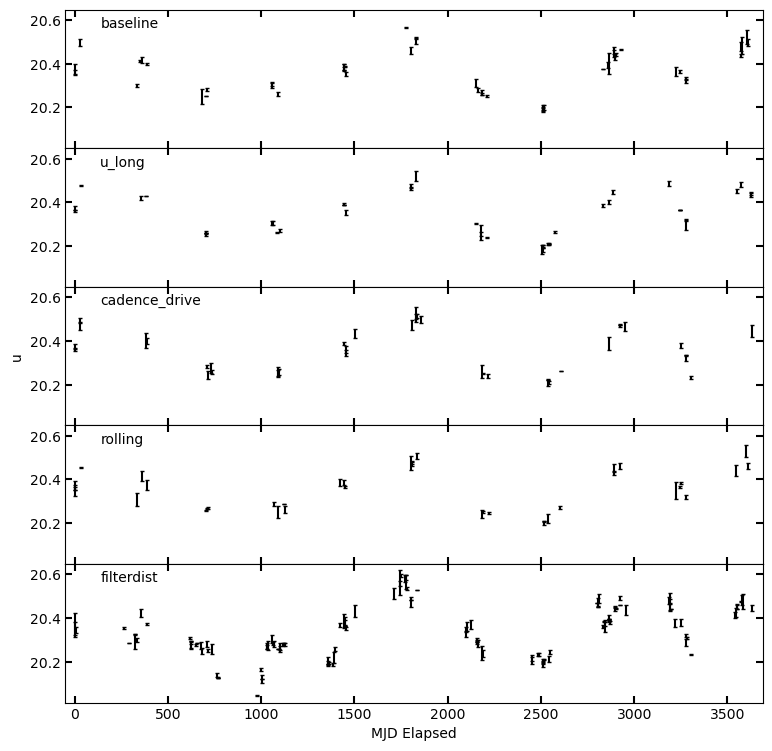

In [31]:
def import_json(file, band, cadstrat):
    """
    Reads the MJDs, fluxes, and flux errors from a JSON file and returns them as numpy arrays.

    Arguments:
        file (str): path to the JSON file
        band (str): band of the light curve
        cadstrat (str): cadence strategy of the light curve
    Returns:
        mjd (np.array): MJDs of the light curve
        y (np.array): fluxes of the light curve
        yerr (np.array):flux errors of the light curve
    """
    f = open(file)
    data = json.load(f)
    mjd, y, yerr = data[band][cadstrat]['mjd'], data[band][cadstrat]['y'], np.abs(data[band][cadstrat]['yerr'])
    return mjd, y, yerr

# Plot the different cadence stragies for a given band to display their relative sampling rates
band = 'u'
fig, axs = plt.subplots(nrows=len(cadences), figsize=(9,9.0), sharex=True, sharey=True, linewidth=2.5)
fig.subplots_adjust(wspace=0, hspace=0)

# Iterate over the cadence strategies
for i in range(len(cadences)):
    mjd, y, yerr = import_json(lcdir_path+'/444.json', band, cadences[i])
    axs[i].errorbar(mjd, y, yerr=yerr, fmt=' ', c='black', zorder=10, capsize=1.5)
    axs[i].text(0.05, 0.95, s=cadences[i], ha='left', va='top', transform=axs[i].transAxes)
    for axis in [axs[i].xaxis, axs[i].yaxis]:
        axis.set_tick_params(width=1.5, length=5)
        axis.set_tick_params(which='both', direction='in', right=True)
        
plt.xlim([-50,3690])
plt.xlabel('MJD Elapsed')
axs[2].set_ylabel(band+'-band Flux')
plt.show()

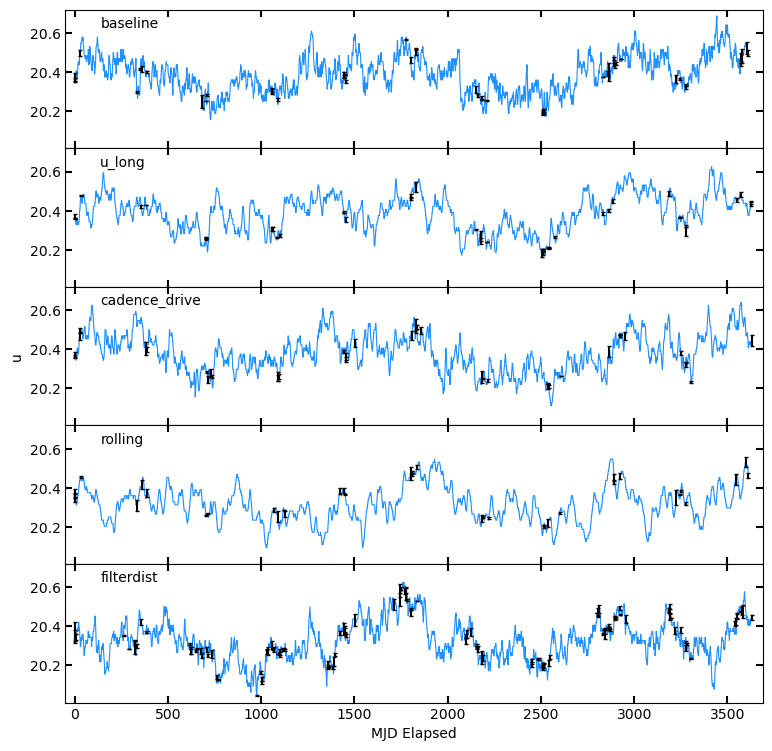

In [37]:
# Model single simulated time series in a given band for demonstration
band, kernel = 'u', 'matern12'
df = pd.read_json(lcdir_path+"/444.json")

fig, axs = plt.subplots(nrows=len(cadences), figsize=(9,9.0), sharex=True, sharey=True, linewidth=2.5)
fig.subplots_adjust(wspace=0, hspace=0)

# Iterate over the cadence strategies, reproduce plot with a random GP sample
for i in range(len(cadences)):
    mjd, y, yerr = import_json(lcdir_path+'/444.json', band, cadences[i])
    axs[i].errorbar(mjd, y, yerr=yerr, fmt=' ', c = 'black', zorder=10, capsize=1.5)
    
    # Model with GPs, draw one sample to add to the previous plot
    gp, samples_df = gp_regression(df=df, band=band, cadence=cadences[i], kernel_form=kernel, 
                                   t_samprate=1, n_samples=1000, lognorm=True)
    t, sample = samples_df['Time (MJD)'], samples_df['Sample 1']
    
    axs[i].plot(t, sample, color = 'dodgerblue', lw = 0.8)
    axs[i].text(0.05, 0.95, s=cadences[i], ha='left', va='top', transform=axs[i].transAxes)
    for axis in [axs[i].xaxis, axs[i].yaxis]:
        axis.set_tick_params(width=1.5, length=5)
        axis.set_tick_params(which='both', direction='in', right=True)
    
plt.xlim([-50,3690])
plt.xlabel('MJD Elapsed')
axs[2].set_ylabel(band+'-band Flux')
plt.show()

In [ ]:
# Model the entire dataset, including for all kernels for model comparison
kernels = ['rq', 'matern12', 'matern32', 'se']
for band in bands:
    for cadence in cadences:
        for kernel in kernels:
            print("Running band: "+band+", "+cadence)
            full_gpreals_df = gpr_on_dataset(lcdir_path, band, cadence, kernel, 
                                             t_samprate=1, n_samples=1000, lognorm=True)
            full_gpreals_df.to_csv(gpreals_path+band+'_'+cadence+'_'+kernel+'.csv', index=True)

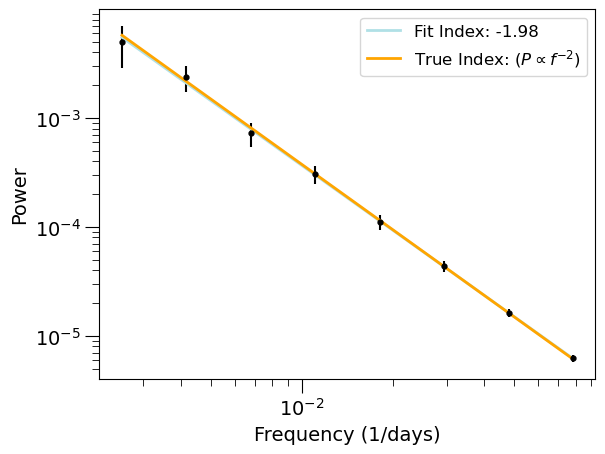

In [45]:
# Define frequency bins for computing the power spectral density (PSD)
min_freq, max_freq, n_bins = 2e-3, 1e-1, 8
freq_bins = np.logspace(np.log10(min_freq), np.log10(max_freq), n_bins+1) # bin edges
freq = np.sqrt(freq_bins[:-1] * freq_bins[1:]) # for plotting

# Import GP realizations for a single simulation for demonstration
band, cadence, kernel = 'u', 'baseline', 'matern12'
full_gpreals_df = pd.read_csv(gpreals_path+'/'+band+'_'+cadence+'_'+kernel+'.csv', 
                                 skiprows=lambda x: x != 0 and x != 1)
full_gpreals_df['GP Sample Dict.'] = full_gpreals_df['GP Sample Dict.'].apply(ast.literal_eval)
gpreals_idx = full_gpreals_df.loc[0, 'GP Sample Dict.']

# Compute the PSD
psd, psderr = psd_across_gpreals(gpreals_idx, freq_bins)

# Fit the PSD with a power law (the true/underlying shape of the PSD)
slope, slope_err = fit_psd(freq, psd, psderr, plot_psd=True)

In [ ]:
# Compute and fit the PSD for all 400 simulated time series for a given band and cadence
n_series = 400 # fit PSDs of the entire dataset
save_path = gpreals_path+'/../'
psd_avg, psd_std, psd_slopes = psdslopes_across_dataset(gpreals_path, n_series, freq_bins, 
                                                        band, cadence, kernel, plot_psd=True)

# Save the results
np.savetxt(save_path+'/'+band+'_'+cadence+'_slopes.dat', psd_slopes)

In [ ]:
# Plot the final results
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(14,16), linewidth=2, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0)
colors = ['mediumpurple','dodgerblue', 'turquoise', 'limegreen', 'orange', 'salmon', '']

for i in range(len(bands)):
    for j in range(len(cadences)):
        # Import the slopes across the dataset 
        slopes = np.loadtxt(save_path+'/'+bands[i]+'_'+cadences[j]+'_slopes.dat')
        avg_slope, slope_err = np.mean(slopes, axis=0)[0], np.std(slopes,axis=0)[0]
        
        # Plot
        axs[i,j].hist(slopes, color=colors[i], alpha=0.7)
        axs[i,j].axvline(x=-2, color='black', linestyle='dashed', lw=2)
        axs[i,j].axvline(x=avg_slope, color=colors[i], linestyle='dotted', lw=2)
        axs[i,j].text(0.972, 0.95, s=r'$\Gamma=$'+str(np.round(avg_slope,2))+r'$\pm$'+str(np.round(slope_err,2)), 
                    ha='right', va='top', transform=axs[i,j].transAxes)
        axs[0,j].set_title(cadences[j])
        axs[i,0].set_ylabel(band, fontsize=14)
        axs[-1,2].set_xlabel('Index', fontsize=14)
        for axis in [axs[i,j].xaxis, axs[i,j].yaxis]:
            axis.set_tick_params(width=1.5, length=5)
            axis.set_tick_params(which='both', direction='in', right=True)
            
plt.savefig(save_path+'slope_dists.pdf', dpi=600, orientation='portrait', format='pdf', pad_inches=0, bbox_inches='tight')
plt.show()